<a id='top'></a>

------


CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Section 8:  Saturday 27 October 10AM EDT

*Rashmi Banthia*

--------

# Classification Methods

[Random Forest](#randomforest)
    - Wine Quality Dataset
    (Tuning Parameters, F1 Score, Grid Search CV, Feature Importances, Classifier calibration)

[XGBoost](#xgboost)
    - Pima Indians Diabetes Database
    - Introduction, Create a quick XGBoost model - no tuning, Use Grid Search (to tune learning_rate and n_estimators), Plot Feature Importance, Early Stopping (With multiple evaluation set and metrics),Calculate AUC, More Parameter tuning

[Support Vector Machine](#svm)
    - Maximal Margin Classifier
    - Support Vectors, Linear Kernel, C parameter, RBF kernel, Gamma Parameter
    - Wine Dataset Example
    - ROC Curve

[Naive Bayes](#naive_bayes)

[Stacking](#stacking)
    - Wine Quality Dataset
   
[HW4](#feature_engineering) - Feature Engineering

------

In [99]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from numpy import loadtxt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import re
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold

# "Support Vector Classifier" 
from sklearn.svm import SVC 
import sklearn.linear_model
import sklearn.svm

from sklearn.naive_bayes import GaussianNB

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap=ListedColormap(dark2_colors)

import warnings

<a id='randomforest'></a>

# Random Forest

[Top](#top)

*Decision Trees:*  Simple and useful for interpretation,  can be applied to both regression and classification problems, 
Trees can be very non-robust. In other words, a small change in the data can cause a large change in the final estimated tree. (High Variance)  https://en.wikipedia.org/wiki/Decision_tree_learning

*Bagging:* Bootstrap Aggregating: Model averaging approach. Reduces variance and helps to avoid overfitting. Bagging constructs a large number of trees with bootstrap samples from a dataset. On average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third of the observations not used to fit a given bagged tree are referred to as the out-of-bag (OOB) observations. Error on these(OOB) obseravations is called out-of-bag error.

https://en.wikipedia.org/wiki/Bootstrap_aggregating


*Random Forest:* Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. 

The random forest adds randomness in two ways. First, it randomly resamples the data with replacement, so each decision tree is being fit on a slightly different set of data. Secondly, for each split in each decision tree, the random forests algorithm only considers a random subset of variables to split on. All trees are trained independently of each other. To make predictions, all trees are queried independently and the majority vote wins.

ISLR Book - Chapter 8

http://nbviewer.jupyter.org/github/cs109/2014/blob/master/homework-solutions/HW5-solutions.ipynb

https://en.wikipedia.org/wiki/Random_forest

https://en.wikipedia.org/wiki/Precision_and_recall



#### Wine Quality Dataset - https://archive.ics.uci.edu/ml/datasets/wine+quality

This data records 11 chemical properties (such as the concentrations of sugar, citric acid, alcohol, pH etc.) of thousands of red and white wines from northern Portugal, as well as the quality of the wines, recorded on a scale from 1 to 10. In this problem, we will only look at the data for red wine.

In [2]:
df = pd.read_csv('data/winequality-red.csv', sep=';')
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,1599
Total Missing (%),0.0%
Total size in memory,150.0 KiB
Average record size in memory,96.1 B
Numeric,12
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


We will use the quality column as our target variable. Save the quality column as a separate numpy array (labeled Y) and remove the quality column from the dataframe.

Also, we will simplify the problem to a binary world in which wines are either "bad" (score<7) or "good" (score>=7).

In [3]:
del pandas_profiling #deleting import because it messes up matplotlib plots later on
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
df = pd.read_csv('data/winequality-red.csv', sep=';')

Y = df['quality'].values
df = df.drop('quality',1)
Y = np.array([1 if y>=7 else 0 for y in Y])
X = df.as_matrix()

In [5]:
#Frequency count for Good/Bad quality wine
pd.Series(Y).value_counts()/df.shape[0]  #~86% bad wines and ~14%good wines

0    0.86429
1    0.13571
dtype: float64

In [6]:
#Building a quick default Random Forest Classification model
#Train Test split 66%:33%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=101)

clf = RandomForestClassifier(random_state=101)
clf.fit(X_train,y_train)

print("Accuracy Score:",accuracy_score(y_test, clf.predict(X_test))) #predicting on 33% and getting accuracy
print("F1 Score:", f1_score(y_test,clf.predict(X_test))) #Do not try to optimize two metrics - decide on a metrics first


Accuracy Score: 0.8768939393939394
F1 Score: 0.4800000000000001


**Tuning Parameters - Random Forest**

**Number of trees**

In [7]:
scores = []

for ne in range(10,150,10):
    clf = RandomForestClassifier(n_estimators = ne, random_state=82)
    score_list = cross_val_score(clf, X, Y, cv=10,n_jobs=-1) #returns accuracy
    #score_list = cross_val_score(clf, X, Y, cv=10, scoring='accuracy') #same as above
    scores.append(score_list)


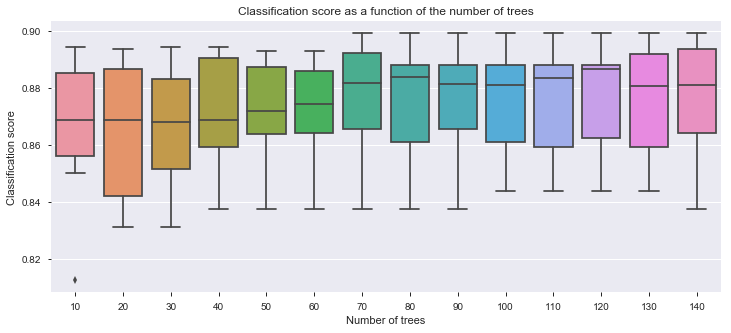

In [8]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of trees')
plt.ylabel('Classification score')
plt.title('Classification score as a function of the number of trees')
sns.boxplot(x=np.arange(10,150,10),y=scores)
plt.show()

Based on above plot, looking at the median classification scores, we will select number of trees = 75. (Consider the computational cost of fitting large number of trees vs. the improvement in the score you get.)

In [9]:
clf = RandomForestClassifier(n_estimators = 75, random_state=101)
clf.fit(X_train,y_train)
accuracy_score(y_test, clf.predict(X_test)) #predicting on 33% and getting accuracy

0.8882575757575758

Based on frequency counts, note that classes are unbalanced. So if we classifiy all wines as 0 we still can still get accuracy of 86%. 

In [10]:
accuracy_score(Y,np.repeat(0,Y.shape))  #Predicting all wines as 0, still getting 86% accuracy -- Not good
# We need better metric

0.8642901813633521

**Evaluation Metrics**

When there are unbalanced classes in a dataset, guessing the more common class will often yield very high accuracy. For this reason, we usually want to use different metrics that are less sensitive to imbalance when evaluating the predictive performance of classifiers. These metrics were originally developed for clinical trials, so to keep with the standard terminology, we define "good" wines (value of 1) as "positive" and the "bad" wines (value of 0) as the "negatives". We then define the following:

$P$ - number of true positives in the sample.

$N$ - number of true negatives in the sample.

$TP$ - number of true positives: how many of the "positive" guesses of the classifier are true.

$FP$ - number of false positives: how many of the "positive" guesses of the classifier are actually negatives.

$TN$ - number of true negatives; similarly, this is how many of the "negative" guesses of the classifier are true.

$FN$ - number of false negatives; how many of the "negative" guesses are actually positives.

When calling the score functions in scikit-learn you obtained the default measure of efficiency, which is called **accuracy**. This is simply the ratio of successful guesses (both positives and negatives) across all samples:
$$\text{accuracy} = \frac{TP + TN}{P+N}.$$
In our case, when the two classes (good and bad wines) are very unbalanced in the sample, we should look for a better measure of efficiency. 

Usually, the goal is to identify the members of the positive class (the rare class) successfully -- this could be either the good wines or the patients presenting a rare disease. It is common practice to define the following ratios:

The **recall** rate (also called the sensitivity or the true positive rate) is the ratio of true positive guesses among all positives:
$$\text{recall} = \frac{TP}{P}=\frac{TP}{TP+FN}.$$
The **precision** is the ratio of the true positive guesses over all the positive guesses:
$$\text{precision} = \frac{TP}{TP+FP}.$$


<img src='data/confusionmatrix.png'></img>

https://en.wikipedia.org/wiki/Confusion_matrix

Example:  When a search engine returns 30 pages only 20 of which were relevant while failing to return 40 additional relevant pages, its precision is 20/30 = 2/3 while its recall is 20/60 = 1/3. So, in this case, precision is "how useful the search results are", and recall is "how complete the results are". (TP = 20, FP = 10, FN = 40)


Because precision and recall both provide valuable information about the quality of a classifier, we often want to combine them into a single general-purpose score. The **F1** score is defined as the harmonic mean of recall and precision:
$$F_1 = \frac{2\times\text{recall}\times\text{precision}}{\text{recall} + \text{precision}}.$$

The harmonic mean of two numbers is closer to the smaller of the two numbers than the standard arithmetic mean. The F1 score thus tends to favor classifiers that are strong in both precision and recall, rather than classifiers that emphasize one at the cost of the other.

**Repeating the cross validation/Number of trees analysis with F1 score**

In [11]:
scores = []

for ne in range(10,150,10):
    clf = RandomForestClassifier(n_estimators = ne, random_state=82)
    score_list = cross_val_score(clf, X, Y, cv=10, scoring='f1')
    scores.append(score_list)


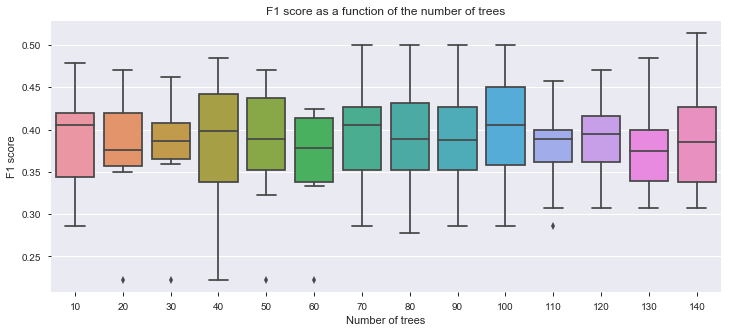

In [12]:
plt.figure(figsize=(12,5))
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 score as a function of the number of trees')
sns.boxplot(x=np.arange(10,150,10),y=scores)
plt.show()

Based on above plot, looking at the median F1 scores, we will select number of trees = 70. (40 trees also seems like a good choice)

**More parameters to tune...**

*max_features:* The number of features to consider when looking for the best split. Default sqrt(n_features) 

*max_depth:* The maximum depth of the tree. If None (default), then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.  

*min_samples_split:* The minimum number of samples required to split an internal node. 

*min_samples_leaf:* The minimum number of samples required to be at a leaf node.  

*class_weight:* The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

More here - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<img src='data/tree-infographic.png'></img>

https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/

**Grid Search**

In [13]:
param_grid = { 
    'n_estimators': [10,20,50,70,100],
    'max_depth': [2,4,6,8,10],
    'class_weight':['balanced'],
    'min_samples_split':[2,4,6],
}

clf = RandomForestClassifier(random_state=82)
CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1)
CV_rfc.fit(X, Y)
print (CV_rfc.best_params_, CV_rfc.best_score_)

clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 4, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)
f1_score(y_test,clf.predict(X_test))  


{'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 50} 0.8692933083176986


0.5362318840579711

Grid Search seemed to help F1 score!

**Feature Importances**

In [14]:
clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 4, 
                             n_estimators= 50, random_state=82)
clf.fit(X,Y)
importance_list = clf.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
df1  = pd.DataFrame([name_list,importance_list]).T
df1.columns = ['Features','Importances']

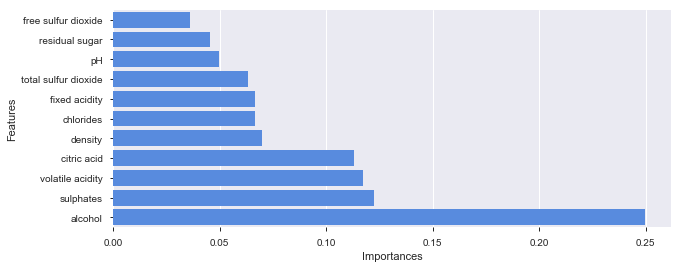

In [15]:
plt.figure(figsize=(10,4))
sns.barplot(x='Importances',y='Features',data=df1, ci=None, color='#4286f4');

**Classifier Calibration** 

(predict, predict_proba, cutoff threshold)
For predictions many classifiers provide two functions (including RF): predict and predict_proba(). predict() gives you actual class values. E.g: 0,1,2 for 3 class predictions. 

predict_proba(): prediction probabilities can be interpreted as the probability that a given prediction point falls into a given class (i.e., given the data  X  and a candidate class  c , the prediction probability states  $P(Y=c|X)$).

In [16]:
clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 4, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)
#The easiest way to convert predict probabilities into predictions is to simply choose the class with probability > 0.5. 
#This is the default behavior of classifiers when we call their predict method. 

preds = (clf.predict_proba(X_test)[:,1]>0.5).astype(int)
(preds == clf.predict(X_test)).all()

True

You can create custom predict functions with different cutoff values. 

In [17]:
"""
cutoff_predict(clf, X, cutoff)

Inputs:
clf: a **trained** classifier object
X: a 2D numpy array of features
cutoff: a float giving the cutoff value used to convert
        predicted probabilities into a 0/1 prediction.

Output:
a numpy array of 0/1 predictions.
"""
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)


clf = RandomForestClassifier( class_weight= 'balanced', max_depth= 10, min_samples_split= 4, 
                             n_estimators= 50, random_state=82)
clf.fit(X_train,y_train)

#Let's try cutoff value of 0.3
preds = cutoff_predict(clf,X_test,0.3) #0.5, 0.7
f1_score(y_test,preds)

0.5775401069518716

<a id='naive_bayes'></a>
## [Naive Bayes Classifiers](http://scikit-learn.org/stable/modules/naive_bayes.html)

[Top](#top)

- Family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) *independence assumptions* between the features.

- A Naive Bayesian model is easy to build, with no complicated iterative parameter estimation which makes it particularly useful for *large datasets*.

- Gaussian Naive Bayes - When dealing with continuous data, a typical assumption is that the continuous values associated with each class are distributed according to a Gaussian distribution. 

- Multinomial Naive Bayes - suitable for classification with discrete features (e.g., word counts for *text classification*). 

- Bernoulli Naive Bayes - for multivariate bernoulli models. Like MultinomialNB, this classifier is suitable for discrete data. The difference is that while MultinomialNB works with occurrence counts, BernoulliNB is designed for binary/boolean features.

### Naive Bayes Classifier:
$$\hat{y} = \underset{k \in{1...k} }{argmax} \  p(C_k) \prod_{i=1}^{n} p(x_i | C_k)$$

We will look at an example from the book and run it on scikit learn - Data Mining - Concepts and Techniques (3rd Ed) Han, Kamber

In [18]:
allelecdf = pd.read_csv("data/AllElectronics.csv")
print(allelecdf.shape)
allelecdf

(14, 5)


,age,income,student,credit_rating,buys_computer
0,youth,high,no,fair,no
1,youth,high,no,excellent,no
2,middle_aged,high,no,fair,yes
3,senior,medium,no,fair,yes
4,senior,low,yes,fair,yes
5,senior,low,yes,excellent,no
6,middle_aged,low,yes,excellent,yes
7,youth,medium,no,fair,no
8,youth,low,yes,fair,yes
9,senior,medium,yes,fair,yes


**Calculating Probabilities: **

Given the following, X = (age=youth, income=medium, student=yes, credit_rating=fair)

(age = Senior, income = low, student = no, credit_rating = excellent)

Would a person buy computer ? 


$P(buys\_computer = yes) = 9/14 = 0.643$

$P(buys\_computer = no) = 5/14 = 0.357$

$P(age = senior \ | \ buys\_computer = Yes) = 3/9 = 0.333$

$P(age = senior \ | \ buys\_computer = No) = 2/5 = 0.4$

$P(income = low \ | \ buys\_computer = Yes) = 3/9 = 0.333$

$P(income = low \ | \ buys\_computer = No) = 1/5 = 0.2$

$P(student = no \ | \ buys\_computer = Yes) = 3/9 = 0.333$

$P(student = no \ | \ buys\_computer = No) = 4/5 = 0.8$

$P(credit\_rating = excellent \ | \ buys\_computer = Yes) = 3/9 = 0.333$

$P(credit\_rating = excellent \ | \ buys\_computer = No) = 3/5 = 0.6$


$P(X \ | \ buys\_computer = Yes) = P(age = senior \ | \ buys\_computer = Yes) \\ \hspace{105pt}\times P(income = low \ | \ buys\_computer = Yes)\\ \hspace{105pt}\times P(student = no \ | \ buys\_computer = Yes) \\ \hspace{105pt}\times P(credit\_rating = excellent \ | \ buys\_computer = Yes)$

$P(X \ | \ buys\_computer = Yes) = 0.333 \times 0.333 \times 0.333 \times 0.333 = 0.0124$

Similarly, 
$P(X \ | \ buys\_computer = No) = 0.4 \times 0.2 \times 0.8 \times 0.6 = 0.0384$

To find the class, $C_i$, that maximizes $P(X|C_i)P(C_i)$, we compute : 

$P(X \ | \ buys\_computer = yes) P(buys\_computer = yes) = 0.0124 \times 0.643 = 0.008$
$P(X \ | \ buys\_computer = no) P(buys\_computer = no) = 0.0384 \times 0.357 = 0.0137$

So, Naive Bayesian classifier predicts buys_computer = No for tuple X.

Lets, run the same using scikit learn:

In [19]:
allelecdf['age'] = allelecdf['age'].map({'youth': 1, 'middle_aged': 2, 'senior':3})
allelecdf['income'] = allelecdf['income'].map({'high': 1, 'medium': 2, 'low':3})
allelecdf['student'] = allelecdf['student'].map({'no': 1, 'yes': 2})
allelecdf['credit_rating'] = allelecdf['credit_rating'].map({'excellent': 1, 'fair': 2})

In [20]:
gnb = GaussianNB()
alleleX = allelecdf[['age','income','student','credit_rating']]
alleleY = allelecdf.buys_computer
res = gnb.fit(alleleX,alleleY)
#(age = Senior, income = low, student = no, credit_rating = excellent)
res.predict(np.array([3,3,1,1]).reshape(1,4)) 

array(['no'], dtype='<U3')

In [21]:
#Example explained in the book 
#(age = youth, income = medium, student = yes, credit rating = fair)
res.predict(np.array([1,2,2,2]).reshape(1,4)) 

array(['yes'], dtype='<U3')

<a id='xgboost'></a>

# XGBoost

[Top](#top)

**Boosting**
- Fits consecutive trees where each solves the net error of the prior trees.  
- Trees are dependent.
- Ensemble of weak learners.

---

XGBoost paper - https://arxiv.org/abs/1603.02754

---

### XGBoost - eXtreme Gradient Boosting 
* An open source tool
    * Computation in C++
    * R/python/Julia interface 
    * Also on Hadoop (Spark and Flink)
    
* A variant of gradient boosting machine
    * Tree based model 
    
* Winning model for several Kaggle Competitions. (Among the 29 challenge winning solutions published at Kaggle’s blog during 2015, 17 solutions used XGBoost)

* Hosted on [github](https://github.com/dmlc/xgboost)

* Created by [Tianqi Chen](http://homes.cs.washington.edu/~tqchen/projects.html) (XGBoost, MXNet)

---


#### Tree Ensemble Model. The final prediction for a given example is the sum of predictions from each tree.

Given: Age, Gender, occupation...
Does the person like computer Games ? 

<img src="http://dmlc.cs.washington.edu/data/img/tree_model.png"/>

Prediction is sum of scores predicted by each of the tree.

---

**Why XGBoost ? **
*  Speed and Model Perfomance

---

**XGBoost Features**

A scalable system for Learning Tree Ensembles

* Model Improvement - Regularized objective for model improvement. 

**System Optimizations**

* Out-of-Core Computing for very large datasets that don’t fit into memory.

* Parallelization of tree construction using all of your CPU cores during training.

* Cache Optimization of data structures and algorithm to make best use of hardware.

* Distributed Computing for training very large models using a cluster of machines.

* GPU Support 

**Algorithm improvements**

* Sparse aware algorithm

* Weighted approximate quantile sketch

---

### Parameters 

http://xgboost.readthedocs.io/en/latest/python/python_api.html

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

(See the above links for all parameters)

**General Parameters** 

booster (default=gbtree), silent, n_jobs (default to maximum number of threads available if not set), ...

**Booster Parameters**

eta(learning_rate), max_depth(Maximum tree depth for base learners), n_estimators (Num. of boosted trees to fit), ...

**Learning Task Parameters**

objective (multi:softprob, reg:logistic, reg:linear), eval_metric(rmse,logloss,auc,etc)...




### We will use [Pima Indian Diabetes](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) dataset from UCI Machine Learning Repository 


```
1. Title: Pima Indians Diabetes Database

2. Sources:
   (a) Original owners: National Institute of Diabetes and Digestive and
                        Kidney Diseases
   (b) Donor of database: Vincent Sigillito (vgs@aplcen.apl.jhu.edu)
                          Research Center, RMI Group Leader
                          Applied Physics Laboratory
                          The Johns Hopkins University
                          Johns Hopkins Road
                          Laurel, MD 20707
                          (301) 953-6231
   (c) Date received: 9 May 1990

3. Past Usage:
    1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
       Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
       the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
       on Computer Applications and Medical Care} (pp. 261--265).  IEEE
       Computer Society Press.

       The diagnostic, binary-valued variable investigated is whether the
       patient shows signs of diabetes according to World Health Organization
       criteria (i.e., if the 2 hour post-load plasma glucose was at least 
       200 mg/dl at any survey  examination or if found during routine medical
       care).   The population lives near Phoenix, Arizona, USA.

       Results: Their ADAP algorithm makes a real-valued prediction between
       0 and 1.  This was transformed into a binary decision using a cutoff of 
       0.448.  Using 576 training instances, the sensitivity and specificity
       of their algorithm was 76% on the remaining 192 instances.

4. Relevant Information:
      Several constraints were placed on the selection of these instances from
      a larger database.  In particular, all patients here are females at
      least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
      routine that generates and executes digital analogs of perceptron-like
      devices.  It is a unique algorithm; see the paper for details.

5. Number of Instances: 768

6. Number of Attributes: 8 plus class 

7. For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

8. Missing Attribute Values: Yes

9. Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")

   Class Value  Number of instances
   0            500
   1            268

10. Brief statistical analysis:

    Attribute number:    Mean:   Standard Deviation:
    1.                     3.8     3.4
    2.                   120.9    32.0
    3.                    69.1    19.4
    4.                    20.5    16.0
    5.                    79.8   115.2
    6.                    32.0     7.9
    7.                     0.5     0.3
    8.                    33.2    11.8


```

In [22]:
xgb.__version__

'0.72'

In [23]:
# load data
dataset = loadtxt('pima_indians_diabetes/pima-indians-diabetes.data', delimiter=",")
print(dataset.shape)
dataset

(768, 9)


array([[  6.   , 148.   ,  72.   , ...,   0.627,  50.   ,   1.   ],
       [  1.   ,  85.   ,  66.   , ...,   0.351,  31.   ,   0.   ],
       [  8.   , 183.   ,  64.   , ...,   0.672,  32.   ,   1.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,   0.245,  30.   ,   0.   ],
       [  1.   , 126.   ,  60.   , ...,   0.349,  47.   ,   1.   ],
       [  1.   ,  93.   ,  70.   , ...,   0.315,  23.   ,   0.   ]])

In [24]:
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
pd.Series(Y).value_counts()/Y.shape[0]  #Frequency %

0.0    0.651042
1.0    0.348958
dtype: float64

In [25]:
colnames = [ 'Number_times_pregnant' , 'Plasma_glucose_concentration','Diastolic_blood_pressure',
'Triceps_skin_fold_thickness','2-Hour_serum_insulin','BMI','Diabetes_pedigree_function','Age(years)'] #'Class_variable'

print(X.shape, Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=2016)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

y_train = np.array(y_train).ravel()

(768, 8) (768,)
(514, 8) (254, 8) (514,) (254,)


Like Scikit learn, this also needs all numeric values. 
Unlike Scikit learn you don't have to explicitly fill missing values (Nans are okay). 

In [26]:
# fit model to training data
model = xgb.XGBClassifier()
%time model.fit(X_train,y_train)  #(use %timeit)

CPU times: user 30 ms, sys: 1.36 ms, total: 31.4 ms
Wall time: 30.3 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [27]:
warnings.filterwarnings('ignore')
y_pred = model.predict(X_test)
#evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0))  #Accuracy without any tuning 


Accuracy: 75.59055%


###  Grid Search with XGBoost (Tuning learning_rate and n_estimators)

- Lower values of learning_rate would require higher number of trees (n_estimators) to be added to the model.
- Learning rate is intended to slow down the adaptation of the model to the training data.

In [28]:
n_estimators = [ 50, 100, 200, 300,400,500,600,700]  
learning_rate = [0.1, 0.5, 0.01, 0.05,0.001,0.0001]  

param_grid1 = {'learning_rate':learning_rate, 'n_estimators':n_estimators}
param_grid1

{'learning_rate': [0.1, 0.5, 0.01, 0.05, 0.001, 0.0001],
 'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700]}

In [29]:
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model,param_grid=param_grid1, scoring="accuracy", verbose=1 )
grid_search.fit(X_train, y_train) #Default 3 folds

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:   12.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.5, 0.01, 0.05, 0.001, 0.0001], 'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [30]:
print(grid_search.best_score_)
print(grid_search.best_params_)  

0.7431906614785992
{'learning_rate': 0.01, 'n_estimators': 500}


In [31]:
#Create a model based on above parameter
model = xgb.XGBClassifier(learning_rate=0.01,n_estimators=500,seed=2017).fit(X_train,y_train)

y_pred = model.predict(X_test)
#evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.5f%%" % (accuracy * 100.0)) 

Accuracy: 75.19685%


In [32]:
model.feature_importances_ 
#This order is based on the columns in the dataset
#[ 'Number_times_pregnant' , 'Plasma_glucose_concentration','Diastolic_blood_pressure',
#'Triceps_skin_fold_thickness','2-Hour_serum_insulin','BMI','Diabetes_pedigree_function','Age(years)'] #'Class_variable'


array([0.05855991, 0.21242905, 0.08156558, 0.08515088, 0.03286525,
       0.205856  , 0.15357037, 0.17000298], dtype=float32)

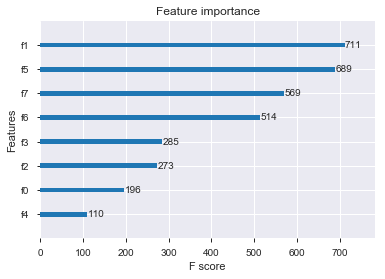

In [33]:
xgb.plot_importance(model)
plt.show()

Default feature importance plot. Features are automatically named according to their index in the input array (X) from F0 to F7. We see that f1 (relates to 'Plasma_glucose_concentration') is the most important feature.

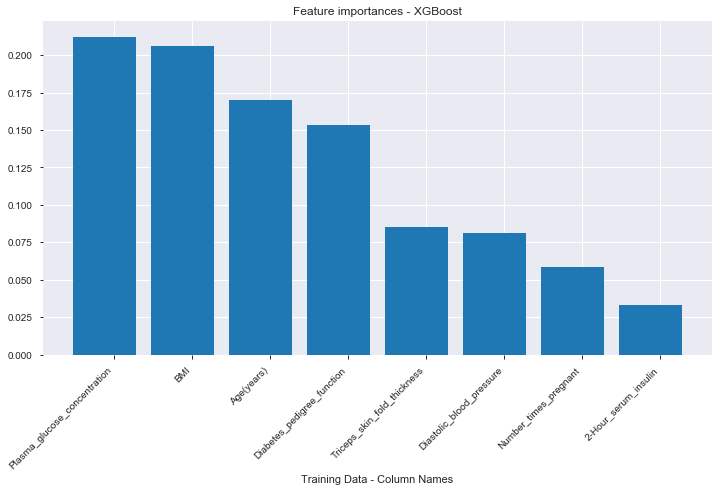

In [34]:
importance = pd.DataFrame({'feature': colnames, 'importance_col': model.feature_importances_})
importance.sort_values(['importance_col', 'feature'], ascending=[0, 1], inplace=True)

#Plotting top n important features
#importance = importance.iloc[0:5,]
plt.figure(1,figsize=(12, 8))
h = plt.bar(range(len(importance.importance_col)),importance.importance_col,label=importance.feature)
plt.subplots_adjust(bottom=0.3)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos,importance.feature[0:20],  ha='right', rotation=45)
plt.title("Feature importances - XGBoost")
plt.xlabel("Training Data - Column Names")
plt.show()

### Early Stopping (Avoid overfitting)

(http://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/) 

- Early stopping is an approach to training complex machine learning models to avoid overfitting.


- It works by monitoring the performance of the model that is being trained on a separate test dataset and stopping the training procedure once the performance on the test dataset has not improved after a fixed number of training iterations.


- It avoids overfitting by attempting to automatically select the inflection point where performance on the test dataset starts to decrease while performance on the training dataset continues to improve as the model starts to overfit.


- The performance measure may be the loss function that is being optimized to train the model (such as logarithmic loss), or an external metric of interest to the problem in general (such as classification accuracy).


In [35]:
# load data
dataset = loadtxt('pima_indians_diabetes/pima-indians-diabetes.data', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=2017)
y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(514, 8) (254, 8) (514,) (254,)


**Evaluate Multiple Sets**

In [36]:
model = xgb.XGBClassifier(n_estimators=1500, seed=2017)
eval_set =  [(X_train, y_train), (X_test, y_test)]

#### Evaluate multiple sets with multiple evaluation metrics

--- 
Following command will fit the model to train and test sets. Log loss (because it's last on the eval_metric list) will be used for early stopping. It will train until 1500(n_estimators) rounds or if logloss hasn't improved in 10 rounds - which ever is earlier.

It returns (for each round) logloss, error and auc for train and test set. (We will plot these later)

In [37]:
model.fit(X_train, y_train, eval_metric=["auc","error","logloss"],
          early_stopping_rounds=10, eval_set=eval_set,verbose=True) 


[0]	validation_0-auc:0.82935	validation_0-error:0.231518	validation_0-logloss:0.657278	validation_1-auc:0.831668	validation_1-error:0.228346	validation_1-logloss:0.657792
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83162	validation_0-error:0.227626	validation_0-logloss:0.627867	validation_1-auc:0.827389	validation_1-error:0.216535	validation_1-logloss:0.628784
[2]	validation_0-auc:0.84852	validation_0-error:0.231518	validation_0-logloss:0.603243	validation_1-auc:0.848508	validation_1-error:0.204724	validation_1-logloss:0.603265
[3]	validation_0-auc:0.848428	validation_0-error:0.231518	validation_0-logloss:0.582272	validation_1-auc:0.852752	validation_1-error:0.204724	validation_1-logloss:0.581755
[4]	validation_0-auc:0.859506	validation_0-error:0.227626	validation_0-logloss:0.564195	validation_1-auc:0.850287	validation_1-error:0.208661	validati

[47]	validation_0-auc:0.93103	validation_0-error:0.157588	validation_0-logloss:0.354716	validation_1-auc:0.861206	validation_1-error:0.224409	validation_1-logloss:0.445093
[48]	validation_0-auc:0.931445	validation_0-error:0.155642	validation_0-logloss:0.353589	validation_1-auc:0.861959	validation_1-error:0.224409	validation_1-logloss:0.444096
[49]	validation_0-auc:0.932177	validation_0-error:0.153696	validation_0-logloss:0.352232	validation_1-auc:0.861685	validation_1-error:0.228346	validation_1-logloss:0.444415
[50]	validation_0-auc:0.933125	validation_0-error:0.151751	validation_0-logloss:0.349272	validation_1-auc:0.861788	validation_1-error:0.228346	validation_1-logloss:0.444768
[51]	validation_0-auc:0.934914	validation_0-error:0.143969	validation_0-logloss:0.346203	validation_1-auc:0.86083	validation_1-error:0.220472	validation_1-logloss:0.445012
[52]	validation_0-auc:0.935753	validation_0-error:0.145914	validation_0-logloss:0.344441	validation_1-auc:0.861583	validation_1-error:0.2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2017,
       silent=True, subsample=1)

Model stopped at 55 iterations with the best iteration at 45. Notice the logloss for iterations 45 to 55.


In [38]:
# retrieve performance metrics
results = model.evals_result()
numrounds = len(results['validation_0']['error'])
x_axis = range(0, numrounds)

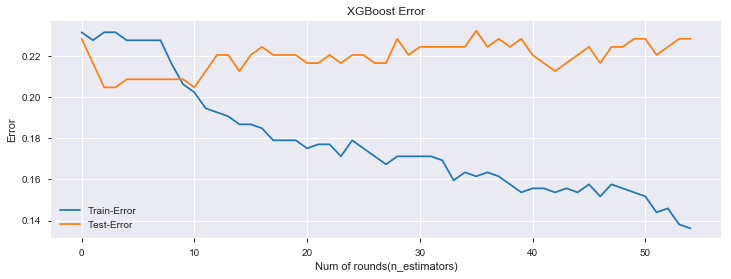

In [39]:
#Plot Error
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_axis, results['validation_0']['error'], label='Train-Error')
ax.plot(x_axis, results['validation_1']['error'], label='Test-Error')
ax.legend()
plt.xlabel('Num of rounds(n_estimators)')
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()


As we increase the n_estimators training error keeps decreasing, not the test error. Early stopping identified n_estimator at 45, which seems  right. 

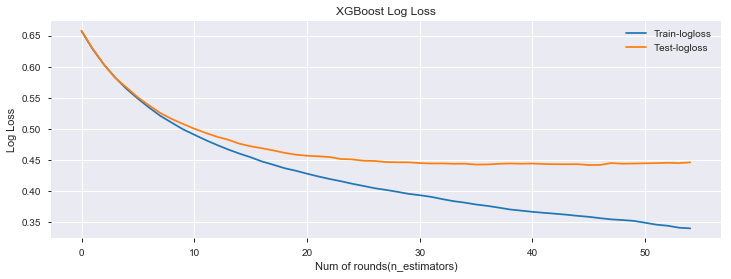

In [40]:
# plot log loss
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train-logloss')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test-logloss')
ax.legend()
plt.xlabel('Num of rounds(n_estimators)')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

As we increase the n_estimators training error keeps decreasing, not the test error. Early stopping identified n_estimator at 45 based on log loss, which is hard to notice in the plot. However, trust the numbers. 

In [41]:
accuracy = accuracy_score(y_test, model.predict(X_test))
print("Accuracy: %.5f%%" % (accuracy * 100.0))

Accuracy: 77.16535%


#### To add your own evaluation metric
https://www.kaggle.com/khozzy/rossmann-store-sales/xgboost-parameter-tuning-template/run/90168/comments


#### More Parameter Tuning ... 

**Regularization terms (reg_alpha L1 regularization, reg_lambda L2 regularization)**

This paper describes how authors used regularization terms in Higgs Boson Kaggle Competition. 
Higgs Boson Discovery with Boosted Trees  - http://www.jmlr.org/proceedings/papers/v42/chen14.pdf

reg_lambda (default=1) - L2 - Similar to Ridge regression [In Ridge reg, Minimum 0 = Linear Reg, as shrinkage penalty parameter increases, the model complexity reduces]

reg_alpha (default=0) - L1 - Similar to Lasso - [Works like Ridge, except coefficients can become exactly zero here]

If you are using XGBoost for regression, tuning these parameters should help. 

**subsample, colsample_bytree **

subsample - Same as GBM subsample. Denotes the fraction of observations to be randomly samples for each tree. Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting. Typical values 0.5 -1 

colsample_bytree - Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.

In [42]:
#Default values are reg_alpha=0 and reg_lambda=1, Ideally tuned using grid search
model = xgb.XGBClassifier(n_estimators=40,reg_lambda=0.1,subsample=0.7, seed = 2017)
model.fit(X_train,y_train)

y_pred = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, model.predict(X_test))
print("Accuracy: %.5f%%" % (accuracy * 100.0)) 

Accuracy: 77.55906%


References:

http://xgboost.readthedocs.io/en/latest/python/python_api.html

http://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

http://homes.cs.washington.edu/~tqchen/data/pdf/BoostedTree.pdf

https://medium.com/@Laurae2/xgboost-hi-im-gamma-what-can-i-do-for-you-and-the-tuning-of-regularization-a42ea17e6ab6#.rcou8f3ml


<a id='svm'></a>

## [Suppor Vector Machines](http://scikit-learn.org/stable/modules/svm.html)

[Top](#top)

- Supervised learning algorithm
- Finds the plane that separates the classes in feature space.
- They are discriminative classifiers 
    - they draw a boundary between clusters of data
    - construct **separating hyperplane** that has the largest distance to the nearest training data point of any class (margin).

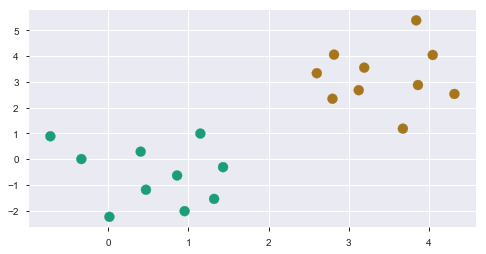

In [43]:
#Try and find a plane that separates the classes in feature space
np.random.seed(1234)
#feature
X = np.random.randn(20,2)
#label (-1 or 1)
y = [-1]*10
y.extend([1]*10)
y = np.array(y)

X[y==1,:] = X[y==1,:] + 3

plt.figure(figsize=(8,4))
plt.scatter(X[:,0], X[:,1], c=y, s=100 ,cmap=dark2_cmap)
plt.show()

### Goal:  Find hyperplane that serves as a decision boundary for the data points
### Equation of hyperplane     
$2D : ax_1 + bx_2 = c$  
$3D: ax_1 + bx_2 + cx_3 = d$  

$w^T x + b = 0$   

$w = (w_1, w_2, ..., w_n)$  
$x = (x_1, x_2, ..., x_n)$  

#### A classifier based on a discriminant function attempts to draw a line (for 2D case) that separates the clusters of data points.
 There are infinite possibilities for that discriminant function. Let's look at how to choose the best one.

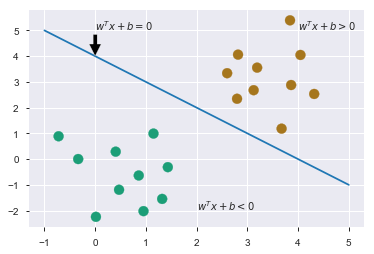

In [44]:
xp = np.linspace(-1, 5) #By default 50 numbers between - 1 and 5 
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=dark2_cmap)
m = -1  # the slope coefficient
b = 4   # the intercept term
yp = m*xp + b
plt.plot(xp, yp) #, c=dark2_colors[3])
plt.annotate('$w^Tx + b = 0$', xy=(0, 4), xytext=(0, 5), size=10,
            arrowprops=dict(facecolor='black', shrink=0.005),)
plt.annotate('$w^Tx + b > 0$', xy=(0, 4), xytext=(4, 5), size=10)
plt.annotate('$w^Tx + b < 0$', xy=(0, 4), xytext=(2, -2), size=10)
plt.show()

### Linear Classifier: infinite possibilities
$y = w^T x + b$      

$y$ is the label

**Decision hyperplane: $w^T x + b = 0$**
- If we know $w$ and $b$, we can classify any data point based on above or below the hyperplane

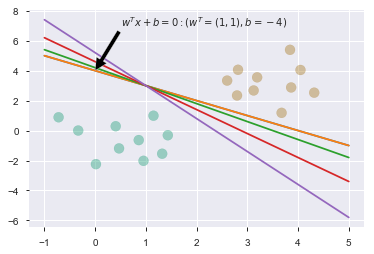

In [45]:
#4 separating hyperplanes out of many choices shown in this plot
xp = np.linspace(-1, 5)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha = 0.4, s=100 ,cmap=dark2_cmap)

m = -1
b = 4
yp = m*xp + b
plt.annotate('$w^Tx + b = 0 : (w^T=(1, 1), b=-4)$', xy=(0, 4), xytext=(0.5, 7), size=10,
            arrowprops=dict(facecolor='black', shrink=0.005),
            )
for i in range(5):
    plt.plot(xp, yp)
    m = m-0.2*i
    b = b+0.2*i
    yp = m*xp + b
    

yp = m*xp + b

### Goal: Classifying by maximizing the margin
Maximal margin hyperplane (also known as the optimal separating hyperplane), which is the separating hyperplane that is farthest from the training observations. The margin is a region of some width around the hyperplane, in the linear case we see this as a band around the line equation. 

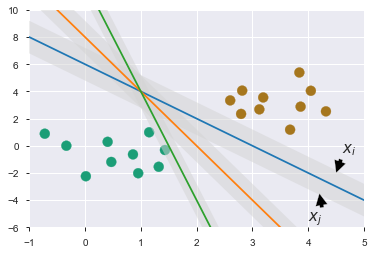

In [46]:
#The maximal margin hyperplane represents the mid-line of the widest slab that we can insert between two classes.
#Among all separating hyperplanes, find the one that makes the biggest gap or margin between the two classes.
xp = np.linspace(-1, 5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap=dark2_cmap)

m = -2; b = 6
for i in range(3):
    yp = m*xp + b
    plt.plot(xp,yp)
    plt.fill_between(xp, yp - 1.2, yp + 1.2, alpha=0.5, facecolor='lightgray')
    m = m-2*(i+1)
    b = b+2*(i+1)
plt.annotate('$x_i$', xy=(4.5, -2), xytext=(4.6,-0.5), size=15,
            arrowprops=dict(facecolor='black', shrink=0.005),
            )
plt.annotate('$x_j$', xy=(4.2, -3.5), xytext=(4.0,-5.5), size=15,
            arrowprops=dict(facecolor='black', shrink=0.005),
            )
plt.xlim(-1, 5);
plt.ylim(-6, 10);

### Support vectors - input data points that lie on the decision boundaries. 
+ Only the support vectors matter in SVM.
+ Moving other points, with out crossing the decision boundary, has no effect on the classification
+ SVMs are not scale invariant
+ **Normalize your data** – mean: 0 , standard error: 1  Both test and training set

- Finding the biggest margin - Constrained optimization problem

In [47]:
# SVM Using Scikit Learn
#use all data as training set except the last one.
X_train = X[:-1]
y_train = y[:-1]
#the last data for testing
X_test = X[-1]
y_test = y[-1:]

clf = SVC(kernel='linear') #default kernel='rbf'
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

<font color='blue'> A cost argument (C Parameter) allows us to specify the cost of a violation to the margin (misclassifying  a point). 
When the cost argument is small, then the margins will be wide and many support vectors will be on the margin 
or will violate the margin. (high bias, low variance).
When the cost argument is large, then the margins will be narrow and there will be few support vectors on 
the margin or violating the margin. (low bias, high variance). </font>

In [48]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.array([xi, yj]).reshape(1,-1))
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

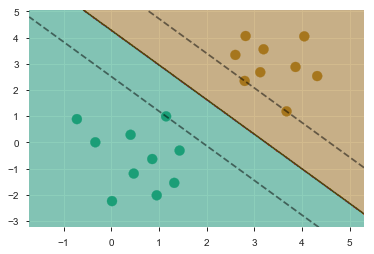

In [49]:
step = 0.02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

Z = clf.predict(np.c_[X.ravel(), Y.ravel()]) #flatten and concatenate

# Showing results using color plot
Z = Z.reshape(X.shape)
plt.contourf(X, Y, Z, cmap=dark2_cmap, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, cmap=dark2_cmap)

plot_svc_decision_function(clf)

# Support vectors: Input vectors that touch the boundary
sv = clf.support_vectors_
#print(sv)
plt.scatter(sv[:, 0], sv[:, 1], s=200, facecolors='none');
plt.show()

### What if the data are not linearly inseparable?
+ consider data that is not linearly separable  
#### XOR problem  - well-known as an example of *not* linearly separable

*RBF Kernel*

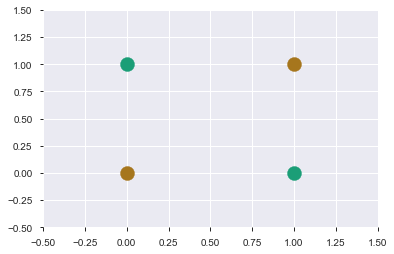

In [50]:
plt.scatter([1,0], [0,1], s=200, c=dark2_colors[0])
plt.scatter([0,1], [0,1], s=200, c=dark2_colors[-1])
plt.xlim(-0.5, 1.5);
plt.ylim(-0.5, 1.5);
plt.show()

In [51]:
X_train = [[1,0]] *50 + [[0,1]] *50 +  [[0,0]] *50 + [[1,1]] *50
X_train = np.array(X_train)+np.random.randn(200,2)/7
y_train = [-1]*100
y_train.extend([1]*100)

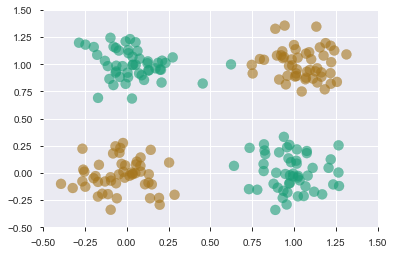

In [52]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=100, cmap=dark2_cmap , alpha =.6)
plt.xlim(-0.5, 1.5);
plt.ylim(-0.5, 1.5);
plt.show()

In [53]:
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

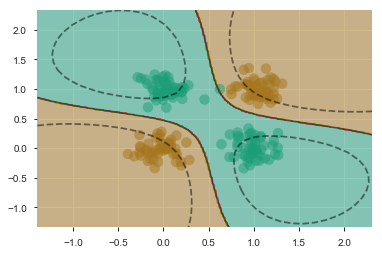

In [54]:
step = 0.02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
X, Y = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

Z = clf.predict(np.c_[X.ravel(), Y.ravel()]) #flatten and concatenate

# Showing results using color plot
Z = Z.reshape(X.shape)
plt.contourf(X, Y, Z, cmap=dark2_cmap, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100, alpha=0.5,cmap=dark2_cmap)

plot_svc_decision_function(clf)

# Support vectors: Input vectors that touch the boundary
sv = clf.support_vectors_
#print(sv)
plt.scatter(sv[:, 0], sv[:, 1], s=200,  facecolors='none');
plt.show()

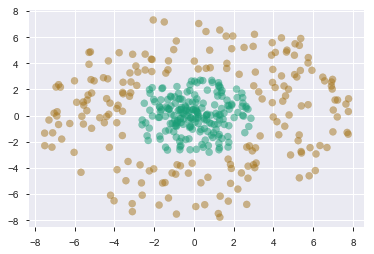

In [55]:
# Generate some cloud of data points
cloud = lambda a, b: np.array(list(zip(a*np.cos(b),a*np.sin(b))))

theta = 2*np.pi*np.random.uniform(0,1, 200)
r = np.random.uniform(0.2,3,200)
X1 = cloud(r, theta)

theta = 2*np.pi*np.random.uniform(0,1, 200)
r = np.random.uniform(3.5,8,200)
X2 = cloud(r, theta)

X = np.vstack([X1, X2])

y = [-1]*200
y.extend([1]*200)

plt.scatter(X[:,0], X[:,1], c=y, s=50,alpha=0.5, cmap=dark2_cmap)
plt.show()

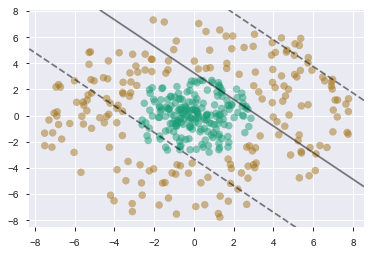

In [56]:
X_train = X[:-1]; y_train = y[:-1]; X_test = X[-1]; y_test = y[-1:]

# fit the model
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
plt.scatter(X[:,0], X[:,1], c=y, s=50,alpha=0.5 , cmap=dark2_cmap)
plot_svc_decision_function(clf)
plt.show()
#Linear kernel doesn't do a good job of seperating the reds and the blues

### Using a non-linear kernel
- Gain linearly separation by mapping the data to a higher dimensional space 
(https://www.youtube.com/watch?v=3liCbRZPrZA)
- The dot product between the features is replaced by a kernel function. A kernel is a function that quantifies the similarity of two observations 
        

### Gaussian Kernel - RBF in scikit learn
- Parameters
    - $C$ is a parameter for soft margin cost function
    - $\gamma$ is the free parameter of the Gaussian radial basis function
        - ### $K(X,X') = exp\left(\gamma \left\| X-X \right\|_2^2\right)$
        
- A cost argument (C Parameter) allows us to specify the cost of a violation to the margin (misclassifying  a point). When the cost argument is small, then the margins will be wide and many support vectors will be on the margin or will violate the margin. (high bias, low variance). When the cost argument is large, then the margins will be narrow and there will be few support vectors on the margin or violating the margin. (low bias, high variance).


- When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. 

Scikit Learn Example - http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [57]:
# fit the model
#clf = SVC(kernel='rbf')  # defaults C=1.0 ; gamma = 1/n_features
#clf = SVC(C = 1000, gamma = 10.0, kernel='rbf')
clf = SVC(gamma = 10.0, kernel='rbf')
#clf = SVC(C = 1000, kernel='rbf')
clf.fit(X_train, y_train) #use all data except the last one as a training set

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

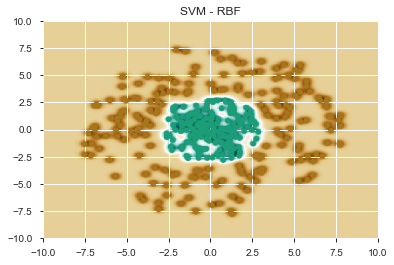

In [58]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 500),
                     np.linspace(-10, 10, 500))
np.random.seed(0)


# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.BrBG_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1,
                       linetypes='--')
plt.scatter(X_train[:, 0], X_train[:, 1], s=30, c=y_train, cmap=dark2_cmap)
plt.axis([-10, 10, -10, 10])
plt.title('SVM - RBF')
plt.show()

# Wine DataSet

In [59]:
wines = pd.read_csv('data/winequality-red.csv',sep=';')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


We need to generate a binary target variable which records wines as either "bad" ($\text{score} < 7$) or "good" ($\text{score} \geq 7)$. We want to create a $Y$ array accordingly such that it only contains zeros ("bad" wines) and ones ("good" wines).   

For the classification, we want also want to remove the *quality* column from the dataset and save it as a pandas series.

In [60]:
wines.quality = np.where(wines.quality >= 7,1,0) 
Y = wines.quality
wines = wines.drop('quality', axis=1)

In [61]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


*Data transformation/preprocessing* 

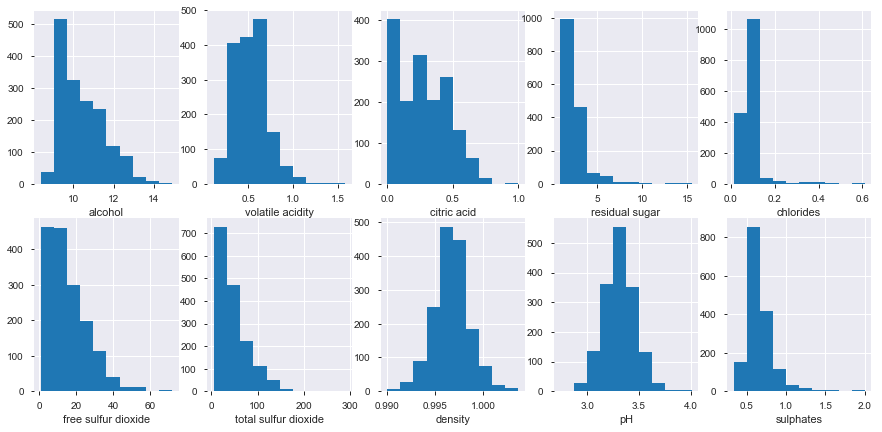

In [62]:
fig, axes=plt.subplots(figsize=(15,7), nrows=2, ncols=5)
#From wines.describe() we see that fixed acidity has mean and median very close, so not plotting it.
cols = ['alcohol', 'volatile acidity', 'citric acid', 'residual sugar','chlorides']
for i,j in enumerate(cols):
    axes[0][i].hist(wines[j])
    axes[0][i].set_xlabel(j)

cols = ['free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates']
for i,j in enumerate(cols):
    axes[1][i].hist(wines[j])
    axes[1][i].set_xlabel(j)

plt.show()

We notice that few attributes are skewed. We will take the log of the complete dataset and plot them again.

In [63]:
wineslog = wines.apply(np.log1p) #log 1plus to avoid taking log of zero

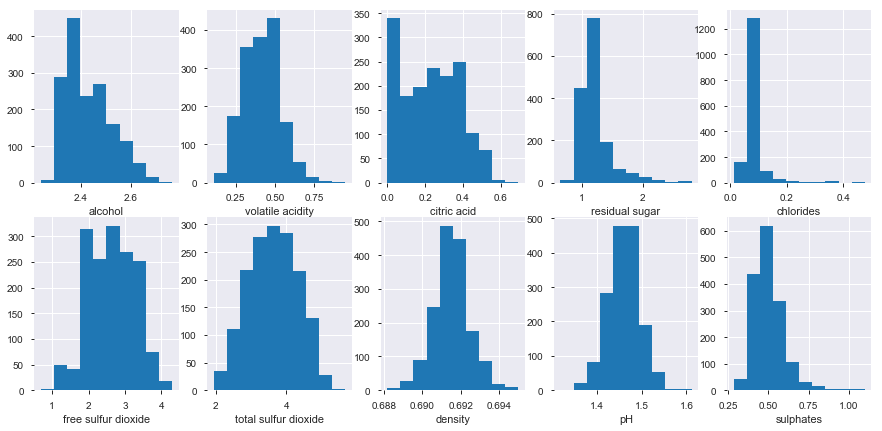

In [64]:
fig, axes=plt.subplots(figsize=(15,7), nrows=2, ncols=5)
#From wines.describe() we see that fixed acidity has mean and median very close, so not plotting it.
cols = ['alcohol', 'volatile acidity', 'citric acid', 'residual sugar','chlorides']
for i,j in enumerate(cols):
    axes[0][i].hist(wineslog[j])
    axes[0][i].set_xlabel(j)

cols = ['free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates']
for i,j in enumerate(cols):
    axes[1][i].hist(wineslog[j])
    axes[1][i].set_xlabel(j)

plt.show()


### Split the data into test and train datasets
For classification, we apply the log transform to all the data, but for the standardization, we want to apply the transform to the test data based on the mean and variance of the training data.  

We start with the original data, redo the log transform, split the data and then apply the standardization.
SciKit Learn has a function to do the standarization in this way.

In [65]:
# Apply the log transform
X = wines.apply(np.log1p).as_matrix()

#Split into training and test set - where the latter is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.15, random_state=10) 
print (X.shape, X_train.shape, X_test.shape)

(1599, 11) (1359, 11) (240, 11)


### Standardize it to standard Normal

In [66]:
from sklearn.preprocessing import StandardScaler

std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [67]:
target_names = ['good wine', 'bad wine']

def show_confusion_matrix(cm):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Accuracy score: 
 0.9041666666666667 

Confusion_matrix: 
 [[199   7]
 [ 16  18]]


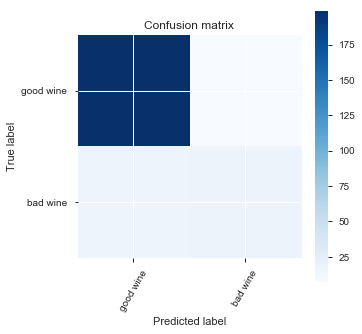

In [68]:
clf = SVC(
        C=10, # Penalty parameter C of the error term; default = 1.0
        cache_size=200, # The size of the kernel cache (in MB).
        class_weight=None, # Set the parameter C of class i to class_weight[i]*C for SVC
        coef0=0.0,  # Independent term in kernel function. Only significant in ‘poly’ and ‘sigmoid’.
        degree=3, # Degree of the polynomial kernel function (‘poly’); default = 3. Ignored by all other kernels.
        gamma=0.1, # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’; auto = 1/n_features
#Higher the value of gamma, will try to exact fit the as per training data set, cause over-fitting problem.
        kernel='rbf',  # Specifies the kernel type to be used in the algorithm; default = "rbf"
        max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit; default = -1
        probability=True, # Whether to enable probability estimates; default = False
        random_state=None, # To set a random state for replicability
        shrinking=True, # Whether to use the shrinking heuristic; default = True
        tol=0.001, # Tolerance for stopping criterion; default = 0.001
        verbose=False  # Enable verbose output; default = False
    )

clf.fit(X_train, Y_train)

Y_pred_svm = clf.predict(X_test)
print()

SVM_predprobability = clf.predict_proba(X_test)
print ('Accuracy score: \n', metrics.accuracy_score(Y_test, Y_pred_svm), '\n')

# Print out confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred_svm)
print ('Confusion_matrix: \n', confusion_matrix)
show_confusion_matrix(confusion_matrix)

### Choices for the (hyper)parameters
+ Which kernel ?
+ Which kernel parameter values (gamma)?
+ Which value for the regularization C?

In [69]:
penalties = [0.1,0.5, 1.0, 5, 10, 100, 1000, 1.0e4]
cv = 10 
acc_scores = np.zeros((len(penalties),cv))
scores_list = []
for i, k in enumerate (penalties):
    clf = SVC(C=k, gamma=0.1, probability=True, random_state=37 )
    acc_scores[i,:] = cross_val_score(clf, X_train, Y_train, cv=cv, scoring='accuracy')  
    scores_list.append(acc_scores[i,:])
#print (acc_scores)

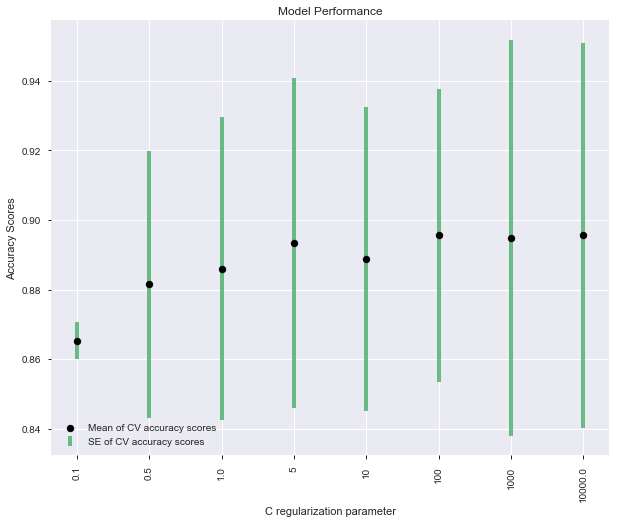

In [70]:
plt.subplots(figsize=(10,8))
ticks = list(range(len(penalties)))
score_means = np.mean(acc_scores, axis=1)
score_std = np.std(acc_scores, axis=1)
score_medians = np.median(acc_scores, axis=1)
plt.scatter(ticks,score_means, c='k', s=50, zorder=3, label= 'Mean of CV accuracy scores')
#Error bars are based on +- 2 Std of mean 
plt.errorbar(ticks, score_means, yerr = 2*score_std,color='#31a354', alpha =0.7, capsize=10, elinewidth=4, linestyle="None", zorder = 1, label= 'SE of CV accuracy scores')
plt.title('Model Performance')
plt.legend(frameon=False, loc='lower left')
plt.ylabel('Accuracy Scores')
plt.xlabel('C regularization parameter')
plt.xticks(ticks, penalties, rotation=90)
_ = plt.show

We choose 5 as value for C, based on mean accuracy scores.

In [71]:
# Warning!!
#The next section runs a 4 parameter grid search and can take a long time to finish.   
#Run this only when you have time - otherwise the results are given below

#from sklearn.model_selection import GridSearchCV   #Performing grid search

#param_test1 = {'C':[0.1,0.5, 1.0, 5, 10, 100], 'gamma':[0.001,0.01, 0.1, 1.0, 2.0], 
#               'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[2,3,4], 'random_state': [37]}
#gsearch1 = GridSearchCV(estimator = SVC(), 
#                        param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=10)
#gsearch1.fit(X_train, Y_train)

#output
#GridSearchCV(cv=10, error_score='raise',
#       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
#  max_iter=-1, probability=False, random_state=None, shrinking=True,
#  tol=0.001, verbose=False),
#       fit_params=None, iid=True, n_jobs=4,
#       param_grid={'C': [0.1, 0.5, 1.0, 5, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1.0, 2.0], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4], 'random_state': [37]},
#       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
#       scoring='accuracy', verbose=0)

In [72]:
#gsearch1.best_params_, gsearch1.best_score_
#output
#({'C': 5, 'degree': 2, 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 37},
# 0.91832229580573954)

### Best choice of kernel and gamma coefficient parameter

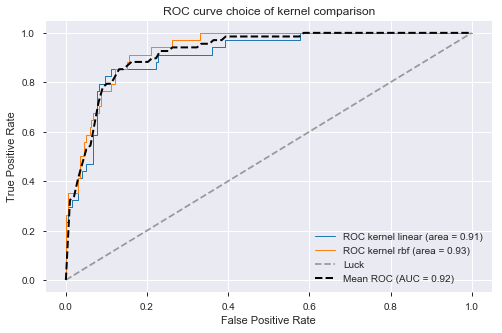

In [73]:
plt.figure(figsize=(8,5))
kernels = ['linear',  'rbf'] #'sigmoid', 'poly'

random_state = np.random.RandomState(37)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i,k in enumerate(kernels):
    clf = SVC(C=100, kernel=k, gamma=1.0, probability=True, random_state=random_state)
    probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC kernel %s (area = %0.2f)' % (kernels[i], roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(kernels)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (AUC = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve choice of kernel comparison')
plt.legend(loc="lower right")
plt.show()

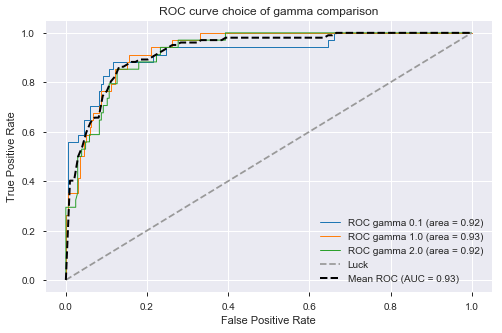

In [74]:
plt.figure(figsize=(8,5))
gammas = [ 0.1, 1.0, 2.0] #0.001,0.01,5.0

random_state = np.random.RandomState(37)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i,k in enumerate(gammas):
    clf = SVC(C=100, kernel='rbf', gamma=k, probability=True, random_state=random_state)
    probas_ = clf.fit(X_train, Y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y_test, probas_[:, 1])
    mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC gamma %s (area = %0.2f)' % (str(gammas[i]), roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(gammas)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (AUC = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve choice of gamma comparison')
plt.legend(loc="lower right")
plt.show()

<a id='stacking'></a>

# Stacked Generalization 

[Top](#top)

Original Paper - http://machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf

<img src = "http://www.chioka.in/wp-content/uploads/2013/09/stacking.png"/>

**'It is usually desirable that the level 0 generalizers are of all “types”, and not just simple variations of one another (e.g., we want surface-fitters, Turing-machine builders, statistical extrapolators, etc., etc.). In this way all possible ways of examining the learning set and trying to extrapolate from it are being exploited. This is part of what is meant by saying that the level 0 generalizers should “span the space”.'**

'Stacked generalization is a means of non-linearly combining generalizers to make a new generalizer, to try to optimally integrate what each of the original generalizers has to say about the learning set. The more each generalizer has to say (which isn’t duplicated in what the other generalizer’s have to say), the better the resultant stacked generalization. Wolpert (1992) Stacked Generalization'



Reference: http://mlwave.com/kaggle-ensembling-guide/

In [75]:
#https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

wines = pd.read_csv('data/winequality-red.csv',sep=';')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [76]:
#Preprocessing 
wines.quality = np.where(wines.quality >= 7,1,0) 
Y = wines.quality
wines = wines.drop('quality', axis=1)

# Apply the log transform
X = wines.apply(np.log1p).as_matrix().astype(np.float)

#Split into training and test set - where the latter is 15% of the total 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.15, random_state=10) 
print (X.shape, X_train.shape, X_test.shape)

#Standardize
X_train = (X_train - X_train.mean(axis=0))/X_train.std(axis=0)
X_test  = (X_test - X_train.mean(axis=0))/X_test.std(axis=0)
print (X.shape, X_train.shape, X_test.shape)

(1599, 11) (1359, 11) (240, 11)
(1599, 11) (1359, 11) (240, 11)


#### Ensembling and Stacking models

In [77]:
# Some useful parameters which will come in handy later on
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS,shuffle=True, random_state=SEED)

# Sklearn classifier
class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    

#### Out of fold predictions

In [78]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


#### Generating our Base First-Level Models

- Random Forest classifier
- Extra Trees classifier
- AdaBoost classifer
- Gradient Boosting classifer
- Support Vector Machine

In [79]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025, 
    'probability':True
    }

In [80]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [81]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, Y_train.values, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, Y_train.values, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, Y_train.values, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, Y_train.values, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,X_train, Y_train.values, X_test) # Support Vector Classifier

print("Training is complete")

Training is complete


#### Second-Level Predictions from the First-level Output

In [82]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
     'GradientBoost': gb_oof_train.ravel(),
     'SVM': svc_oof_train.ravel()                                   
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVM
0,0.494316,0.053339,0.000010,0.024217,0.146169
1,0.497301,0.042554,0.000045,0.018175,0.089538
2,0.479380,0.125117,0.000011,0.113212,0.035995
3,0.502193,0.318487,0.065128,0.354053,0.154702
4,0.497967,0.184149,0.000353,0.177002,0.172997


In [83]:
#You are looking for models that score high individually but uncorrelated 
#Here I skipped checking how good/bad individual models are, only to demo the stacking procedure.
base_predictions_train.corr()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest,SVM
AdaBoost,1.000000,0.547962,0.401888,0.503942,0.278273
ExtraTrees,0.547962,1.000000,0.718571,0.971698,0.549069
GradientBoost,0.401888,0.718571,1.000000,0.766767,0.368668
RandomForest,0.503942,0.971698,0.766767,1.000000,0.530447
SVM,0.278273,0.549069,0.368668,0.530447,1.000000


In [84]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

#### Second level learning model via XGBoost

In [85]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,  
 min_child_weight= 2,
 gamma=0.9,   #Regularization parameter                     
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, Y_train)

predictions = gbm.predict_proba(x_test)

In [86]:
accuracy_score(Y_test,predictions[:,1]>0.5)

0.8208333333333333

<a id='feature_engineering'></a>

# HW 4 -  Feature Engineering

- No models/algorithms
- It's data mining - in literal sense

In [87]:
train = pd.read_csv('../../homework/hw4/kaggle/train_data.csv')
test = pd.read_csv('../../homework/hw4/kaggle/test_data.csv')

In [88]:
train.output.value_counts()

1    3873
0     711
Name: output, dtype: int64

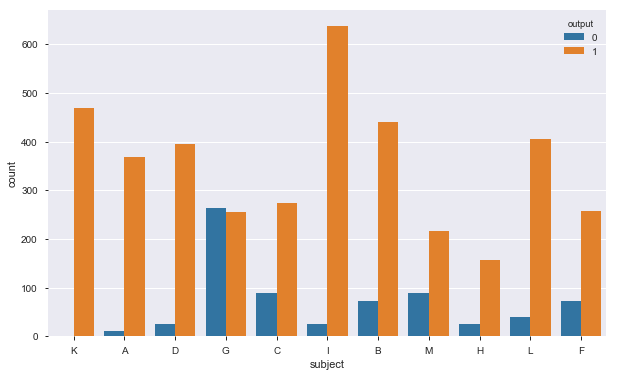

In [89]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="subject", hue="output", data=train);

Notice that Subject K is always 1

In [90]:
pd.Series(train[train.subject=='K']['output']).value_counts() 
#Yes K is all 1's

1    468
Name: output, dtype: int64

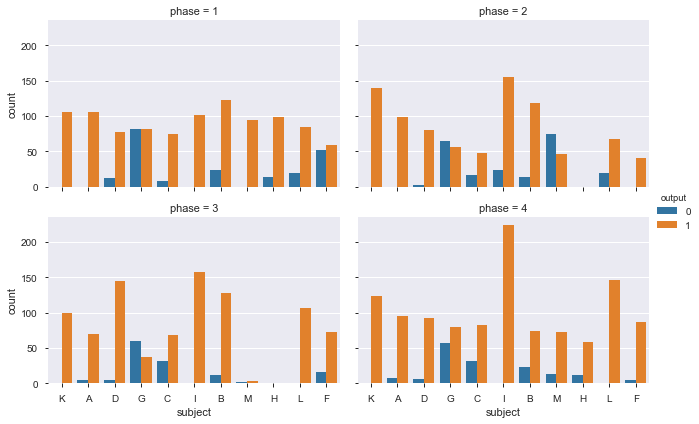

In [91]:
sns.factorplot(x="subject", hue="output", col="phase",data=train, kind="count", col_wrap=2 , size=3, aspect=1.5);

- Subject K is always 1 (as noticed in previous plot)
- In phase 1 : Subject A, I, M, K are always 1 
- In phase 2 : Subject A, F, K are always 1  (Seems like no data for Phase 2, Subject H)
- In phase 3 : Subject I, L, K are always 1 
- In phase 4 : Subject L, K are always 1, (Subject I is almost all 1's)

In [92]:
train['indicator']='train'
test['indicator']='test'

Y = train.output
train.drop('output',inplace=True, axis=1)

In [93]:
train_test = pd.concat([train,test])
train_test.reset_index(inplace=True, drop=True) #drop index
train_test.shape

(6316, 670)

In [94]:
#Creating Features
train_test['SubjectK'] = 0 
train_test.loc[train_test[train_test.subject=='K'].index,'SubjectK']=1  

In [95]:
#Step by step
i1 = train_test[((train_test.phase==1) & (train_test.subject=='A'))].index
arr = np.zeros(train_test.shape[0],dtype=int)
arr[i1]=1
train_test['SubA_Phase1']=arr

#concise
train_test['SubI_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='I'))].index,'SubI_Phase1'] = 1

train_test['SubM_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='M'))].index,'SubM_Phase1'] = 1

train_test['SubA_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='A'))].index,'SubA_Phase2'] = 1

train_test['SubF_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='F'))].index,'SubF_Phase2'] = 1

train_test['SubI_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='I'))].index,'SubI_Phase3'] = 1

train_test['SubL_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='L'))].index,'SubL_Phase3'] = 1

train_test['SubL_Phase4'] = 0
train_test.loc[train_test[((train_test.phase==4) & (train_test.subject=='L'))].index,'SubL_Phase4'] = 1
#possibly add I, phase4 = 1 too.

In [96]:
train_1 = train_test[train_test.indicator=='train']
test_1 = train_test[train_test.indicator=='test']
train_1.reset_index(inplace=True,drop=True)
test_1.reset_index(inplace=True,drop=True)

train_1 = train_1.drop(['state','subject','phase','indicator'], axis=1)
test_1 = test_1.drop(['state','subject','phase','indicator'], axis=1)


In [97]:
#Create a model on complete training set 
#Leaving CV for your HW
model = xgb.XGBClassifier(seed=82, n_estimators=1100 , max_depth=3, colsample_bylevel=0.8,
                          colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                           scale_pos_weight = 0.18357862) #missing = -999

model.fit(train_1,Y, eval_metric='auc')
preds = model.predict_proba(test_1) #submit these predictions


In [98]:
submithis = pd.DataFrame([test_1.index,preds[:,1]]).T
submithis.columns = ['id','output']
submithis.id = submithis.id.astype(int)
#submithis.to_csv('submitthis.csv',index=False)  #~0.68756

### Cross validation - Right way 

Ref: Elements of Statistical Learning (Section 7.10.2) - Hastie, Tibshirani, Friedman


1. Divide the samples into K cross-validation folds (groups) at random. 
2. For each fold k = 1,2,...,K
    
    (a)Find a subset of “good” predictors that show fairly strong (univariate) correlation with the class labels, using all of the samples except those in fold k.
    
    (b) Using just this subset of predictors, build a multivariate classifier, using all of the samples except those in fold k.
    
    (c) Use the classifier to predict the class labels for the samples in fold k.

[Top](#top)